In this notebook, we'll identify any lidar clips that do not completely cover the inventory plot and copy any nearly-complete coverage plots to our processed data folder.

In [1]:
import geopandas as gpd
import pandas as pd
import glob
import shutil
import os
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# USFS Region 6 Albers Equal Area Map Projection, proj4 string format
# we'll use this later for calculating the area of each plot
USFS_ALB = '+proj=aea +lat_1=41 +lat_2=47 +lat_0=44 +lon_0=-120 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs'

In [3]:
PLOT_CLIPS = '../data/interim/lidar/plot_clips/'

In [4]:
ha_clip_dirs = [x for x,_,_ in os.walk(PLOT_CLIPS) if 'hectare_clips' in x]
ha_clip_dirs

['../data/interim/lidar/plot_clips/dnr_portal/usfs_plots/hectare_clips',
 '../data/interim/lidar/plot_clips/dnr_portal/dnr_plots/hectare_clips',
 '../data/interim/lidar/plot_clips/noaa/blm_plots/hectare_clips',
 '../data/interim/lidar/plot_clips/noaa/usfs_plots/hectare_clips',
 '../data/interim/lidar/plot_clips/noaa/dnr_plots/hectare_clips',
 '../data/interim/lidar/plot_clips/osu/usfs_plots/hectare_clips',
 '../data/interim/lidar/plot_clips/osu/blm_plots/hectare_clips']

In [5]:
plot_clip_dirs = [x for x,_,_ in os.walk(PLOT_CLIPS) if 'plot_clips' in x.split('/')[-1]]
plot_clip_dirs

['../data/interim/lidar/plot_clips/dnr_portal/usfs_plots/plot_clips',
 '../data/interim/lidar/plot_clips/dnr_portal/dnr_plots/plot_clips',
 '../data/interim/lidar/plot_clips/noaa/blm_plots/plot_clips',
 '../data/interim/lidar/plot_clips/noaa/usfs_plots/plot_clips',
 '../data/interim/lidar/plot_clips/noaa/dnr_plots/plot_clips',
 '../data/interim/lidar/plot_clips/osu/usfs_plots/plot_clips',
 '../data/interim/lidar/plot_clips/osu/blm_plots/plot_clips']

In [6]:
shps = glob.glob(os.path.join(ha_clip_dirs[0], '*.shp'))
len(shps)

105

In [7]:
dnr_plots = [d for d in plot_clip_dirs if 'dnr_plots' in d]
dnr_hectares = [d for d in ha_clip_dirs if 'dnr_plots' in d]
dnr_plots, dnr_hectares

(['../data/interim/lidar/plot_clips/dnr_portal/dnr_plots/plot_clips',
  '../data/interim/lidar/plot_clips/noaa/dnr_plots/plot_clips'],
 ['../data/interim/lidar/plot_clips/dnr_portal/dnr_plots/hectare_clips',
  '../data/interim/lidar/plot_clips/noaa/dnr_plots/hectare_clips'])

In [8]:
blm_plots = [d for d in plot_clip_dirs if 'blm_plots' in d]
blm_hectares = [d for d in ha_clip_dirs if 'blm_plots' in d]
blm_plots, blm_hectares

(['../data/interim/lidar/plot_clips/noaa/blm_plots/plot_clips',
  '../data/interim/lidar/plot_clips/osu/blm_plots/plot_clips'],
 ['../data/interim/lidar/plot_clips/noaa/blm_plots/hectare_clips',
  '../data/interim/lidar/plot_clips/osu/blm_plots/hectare_clips'])

In [9]:
usfs_plots = [d for d in plot_clip_dirs if 'usfs_plots' in d]
usfs_hectares = [d for d in ha_clip_dirs if 'usfs_plots' in d]
usfs_plots, usfs_hectares

(['../data/interim/lidar/plot_clips/dnr_portal/usfs_plots/plot_clips',
  '../data/interim/lidar/plot_clips/noaa/usfs_plots/plot_clips',
  '../data/interim/lidar/plot_clips/osu/usfs_plots/plot_clips'],
 ['../data/interim/lidar/plot_clips/dnr_portal/usfs_plots/hectare_clips',
  '../data/interim/lidar/plot_clips/noaa/usfs_plots/hectare_clips',
  '../data/interim/lidar/plot_clips/osu/usfs_plots/hectare_clips'])

In [10]:
usfs_plot_shps = [glob.glob(os.path.join(d,'*.shp')) for d in usfs_plots]
# flatten the list of shapefiles
usfs_plot_shps = [shp for shps in usfs_plot_shps for shp in shps]
len(usfs_plot_shps)

647

In [11]:
blm_plot_shps = [glob.glob(os.path.join(d,'*.shp')) for d in blm_plots]
# flatten the list of shapefiles
blm_plot_shps = [shp for shps in blm_plot_shps for shp in shps]
len(blm_plot_shps)

1435

In [12]:
dnr_plot_shps = [glob.glob(os.path.join(d,'*.shp')) for d in dnr_plots]
# flatten the list of shapefiles
dnr_plot_shps = [shp for shps in dnr_plot_shps for shp in shps]
len(dnr_plot_shps)

4278

In [13]:
dnr_plot_gdfs = [gpd.read_file(shp).to_crs({'init':'epsg:4326'}) for shp in dnr_plot_shps]
dnr_plot_gdf = pd.concat(dnr_plot_gdfs, axis=0, ignore_index=True, sort=True)
dnr_plot_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4273 entries, 0 to 4272
Data columns (total 12 columns):
file_name     4273 non-null object
geometry      4273 non-null object
max_x         4273 non-null float64
max_y         4273 non-null float64
max_z         4273 non-null float64
min_x         4273 non-null float64
min_y         4273 non-null float64
min_z         4273 non-null float64
num_points    4273 non-null float64
point_size    4273 non-null float64
point_type    4273 non-null float64
version       4273 non-null object
dtypes: float64(9), object(3)
memory usage: 400.7+ KB


In [14]:
basenames = [os.path.basename(shp).split('.')[0] for shp in dnr_plot_shps]
missing = [x for x in basenames if x not in dnr_plot_gdf.file_name.apply(lambda x: x.split('.')[0]).values]
len(missing), len(basenames)

(5, 4278)

In [15]:
missing

['81c6c096-2710-4374-b848-0b209ca72a0c_kitsap_2000',
 '7af6509c-cb39-4d2f-ab59-08e88c6928ac_clallam-county_2001-2002',
 'bc9db40a-ca12-48bb-bd32-be8f51d49cb7_kitsap_2000',
 '0aa62f02-d7a0-45df-86ed-49f94e5b0e67_kitsap_2000',
 'b8d0b1b7-ddfe-44b1-9815-ebccf994e3c2_kitsap_2000']

In [16]:
def get_wild_file(path):
    dirname, basename = os.path.split(path)
    return os.path.join(dirname, basename.split('.')[0]+'.*')

In [17]:
paths = [get_wild_file(x) for x in dnr_plot_shps if os.path.basename(x).split('.')[0] not in missing]
dnr_plot_gdf['path'] = paths

In [18]:
dnr_plot_gdf['area_m2'] = dnr_plot_gdf.to_crs(USFS_ALB).area
dnr_plot_gdf['acres'] = dnr_plot_gdf['area_m2'] / 4046.86

In [19]:
# keep the plot clip that has the largest area among duplicates
dnr_plot_gdf = dnr_plot_gdf.sort_values(by=['file_name', 'acres']).drop_duplicates(subset='file_name', keep='last')

In [20]:
# drop plots that have more than 25% of the plot area missing from the point cloud
dnr_plot_gdf = dnr_plot_gdf.loc[dnr_plot_gdf.acres >= (0.75* 0.10)]

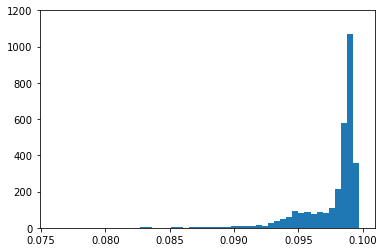

In [21]:
plt.hist(dnr_plot_gdf.acres, bins=50)
plt.ylim(0,1200);

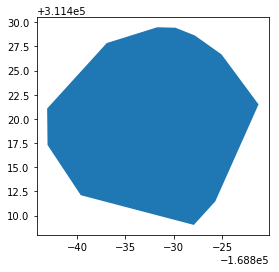

In [22]:
dnr_plot_gdf.loc[dnr_plot_gdf.acres < (0.77* 0.10)].sort_values(by='acres', ascending=False).iloc[[0]].to_crs(USFS_ALB).plot()

In [23]:
def get_hec_path(plot_path):
    dirname, basename = os.path.split(plot_path)
    hec_dir = os.path.abspath(os.path.join(dirname, '..', 'hectare_clips'))
    return os.path.join(hec_dir, basename)

In [24]:
# move the remaining plot clips to the processed directory
DEST = '../data/processed/lidar/plot_clips/dnr_plots/plot_clips/'
for p in dnr_plot_gdf.path:
    for f in glob.glob(p):
        shutil.copy(f, DEST)
    for f in glob.glob(get_hec_path(p)):
        shutil.copy(f, get_hec_path(DEST))

moved = glob.glob(os.path.join(DEST,'*.laz'))
print('Moved {} laz files to {}'.format(len(moved), DEST))

Moved 3118 laz files to ../data/processed/lidar/plot_clips/dnr_plots/plot_clips/


In [25]:
dnr_plot_gdf.to_file('../data/processed/lidar/plot_clips/dnr_plots/dnr_plots_lidar_coverage.shp')

In [26]:
usfs_plot_gdfs = [gpd.read_file(shp).to_crs({'init':'epsg:4326'}) for shp in usfs_plot_shps]
usfs_plot_gdf = pd.concat(usfs_plot_gdfs, axis=0, ignore_index=True, sort=True)
usfs_plot_gdf['path'] = [get_wild_file(f) for f in usfs_plot_shps]
usfs_plot_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 647 entries, 0 to 646
Data columns (total 13 columns):
file_name     647 non-null object
geometry      647 non-null object
max_x         647 non-null float64
max_y         647 non-null float64
max_z         647 non-null float64
min_x         647 non-null float64
min_y         647 non-null float64
min_z         647 non-null float64
num_points    647 non-null int64
point_size    647 non-null int64
point_type    647 non-null int64
version       647 non-null object
path          647 non-null object
dtypes: float64(6), int64(3), object(4)
memory usage: 65.8+ KB


In [27]:
usfs_plot_gdf['area_m2'] = usfs_plot_gdf.to_crs(USFS_ALB).area
usfs_plot_gdf['acres'] = usfs_plot_gdf['area_m2'] / 4046.86
usfs_plot_gdf = usfs_plot_gdf.loc[usfs_plot_gdf.acres >= (0.90 * 0.25)]

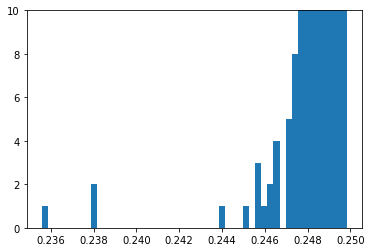

In [28]:
plt.hist(usfs_plot_gdf.acres, bins=50)
plt.ylim(0,10);

In [ ]:
# usfs_plot_gdf.loc[usfs_plot_gdf.acres < (0.80* 0.25)].sort_values(by='acres', ascending=False).iloc[[0]].to_crs(USFS_ALB).plot()

In [42]:
# move the remaining plot clips to the processed directory
DEST = '../data/processed/lidar/plot_clips/usfs_plots/plot_clips/'
for p in usfs_plot_gdf.path:
    for f in glob.glob(p):
        shutil.copy(f, DEST)
    for f in glob.glob(get_hec_path(p)):
        shutil.copy(f, get_hec_path(DEST))

moved = glob.glob(os.path.join(DEST,'*.laz'))
print('Moved {} laz files to {}'.format(len(moved), DEST))

Moved 565 laz files to ../data/processed/lidar/plot_clips/usfs_plots/plot_clips/


In [43]:
usfs_plot_gdf.to_file('../data/processed/lidar/plot_clips/usfs_plots/usfs_plots_lidar_coverage.shp')

In [44]:
blm_plot_gdfs = [gpd.read_file(shp).to_crs({'init':'epsg:4326'}) for shp in blm_plot_shps]
blm_plot_gdf = pd.concat(blm_plot_gdfs, axis=0, ignore_index=True, sort=True)
blm_plot_gdf['path'] = [get_wild_file(f) for f in blm_plot_shps]
blm_plot_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1435 entries, 0 to 1434
Data columns (total 13 columns):
file_name     1435 non-null object
geometry      1435 non-null object
max_x         1435 non-null float64
max_y         1435 non-null float64
max_z         1435 non-null float64
min_x         1435 non-null float64
min_y         1435 non-null float64
min_z         1435 non-null float64
num_points    1435 non-null int64
point_size    1435 non-null int64
point_type    1435 non-null int64
version       1435 non-null object
path          1435 non-null object
dtypes: float64(6), int64(3), object(4)
memory usage: 145.8+ KB


In [45]:
blm_plot_gdf['area_m2'] = blm_plot_gdf.to_crs(USFS_ALB).area
blm_plot_gdf['acres'] = blm_plot_gdf['area_m2'] / 4046.86
blm_plot_gdf = blm_plot_gdf.loc[blm_plot_gdf.acres >= (0.90 * 1/8)]

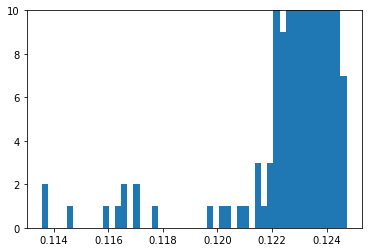

In [46]:
plt.hist(blm_plot_gdf.acres, bins=50)
plt.ylim(0,10);

In [ ]:
# blm_plot_gdf.loc[blm_plot_gdf.acres < (0.90 * 1/8)].sort_values(by='acres', ascending=False).iloc[[0]].to_crs(USFS_ALB).plot()

In [47]:
# move the remaining plot clips to the processed directory
DEST = '../data/processed/lidar/plot_clips/blm_plots/plot_clips/'
for p in blm_plot_gdf.path:
    for f in glob.glob(p):
        shutil.copy(f, DEST)
    for f in glob.glob(get_hec_path(p)):
        shutil.copy(f, get_hec_path(DEST))

moved = glob.glob(os.path.join(DEST,'*.laz'))
print('Moved {} laz files to {}'.format(len(moved), DEST))

Moved 1139 laz files to ../data/processed/lidar/plot_clips/blm_plots/plot_clips/


In [48]:
blm_plot_gdf.to_file('../data/processed/lidar/plot_clips/blm_plots/blm_plots_lidar_coverage.shp')